# HW3: Building an AI Game Master (100pts)

*Author: Andrew Zhu (andrz@seas.upenn.edu)*

In this homework, we'll use Kani to build a simple Game Master (GM) for the [Mausritter TTRPG](https://losing-games.itch.io/mausritter). Your GM will help walk you through creating a mouse and rolling dice to overcome challenges in the game. Along the way, you'll learn the basics of the [Kani library](https://kani.readthedocs.io/en/latest/), function calling with LLMs, and how a LLM can use structured information to act as a game state manager.

We won't implement more complex systems like combat or spellcasting in this homework, but extending this system to make a more comprehensive GM (e.g. adding inventory tracking, combat, spellcasting, structured tracking of NPCs, ...) would make for a great class final project.

## What You'll Need

- A copy of the [Mausritter rules](https://losing-games.itch.io/mausritter) (available for free on itch.io)
- Your [Open AI API key](https://platform.openai.com/api-keys)
- Recommended: the [Kani documentation](https://kani.readthedocs.io/en/latest/)
- Optional: the [d20 documentation](https://d20.readthedocs.io/en/latest/start.html)

# Part 0: Setup

*Reference: [Installation (Kani Documentation)](https://kani.readthedocs.io/en/latest/install.html)*

First, let's install the libraries we're using and configure Kani to use the Helicone proxy. Kani requires Python 3.10 or higher - if you encounter an error saying "No matching distribution found", you may need to upgrade your Python version.

## Virtual Environment

Before we get started, I recommend setting up a virtual environment for this homework. To set up a virtual environment, use the following terminal commands:

Mac/Linux:
```shell
python3.10 -m venv ./venv
./venv/bin/activate
pip install jupyter
```

Windows:
```shell
python3.10 -m venv venv
venv\Scripts\activate.bat
pip install jupyter
```

You may need to restart your IDE after creating a new virtual environment for it to detect the interpreter. Now, when we install dependencies, it won't affect the global environment.

## Line Wrapping

If you're using VSCode, you may want to enable word wrap for your notebook so long outputs on a single line automatically fold to multiple lines. You can find the wordwrap option by clicking on the gear icon in the upper right hand corner of your .ipynb file, then click "Customize Notebook Layout", then scroll down to the bottom of the settings and select "Notebook Output Word Wrap".

In [1]:
# Install dependencies
# !pip install -q d20 'kani[openai]' openai

We'll use GPT-4 as our LLM of choice, so we'll configure it as our *engine* (a Kani concept used to provide a standard interface to a LLM).

<div>
<img src="https://kani.readthedocs.io/en/latest/_images/concepts-figure.png" width="700"/>
</div>

You should set your OpenAI API Key (which you can find [here](https://platform.openai.com/api-keys)) on the terminal with the command `export OPENAI_API_KEY=sk-helicone-cp-###########`. If you're using VS Code, you can launch it from your terminal with the `code` command and prefix it with this export statement on the same line. For example:

```
cd your/homework/dir
source venv/bin/activate
OPENAI_API_KEY=sk-helicone-cp-###########  code .
```

We'll use the `engine` global throughout the rest of this homework.

In [2]:
# Set up a GPT-4 engine using the Helicone proxy
from kani.engines.openai import OpenAIEngine
from dotenv import load_dotenv
import os
load_dotenv()

engine = OpenAIEngine(api_key=os.environ["OPENAI_API_KEY"], model="gpt-4o-mini")

*Note*: Although the total cost is expected to be under $5 for the entire homework, you can use more cost-effective models such as `gpt-3.5-turbo` or `davinci-002` to reduce expenses on GPT-4 prompting.

# Part 1: Dice Rolling & Function Calling

First, let's get familiar with the libraries we're going to use. 

## 1.1: Dice Rolling

To implement dice rolling, we'll use `d20`, a Python dice library I wrote for D&D. This library parses RPG dice notation and rolls the specified dice. For this homework, we'll use its output as Markdown, but if you're interested in a deeper dive into the library, the output is a [structured eval tree](https://d20.readthedocs.io/en/latest/expression.html).

Mausritter uses standard RPG dice notation throughout.

For example:
- `d20` means: Roll a single 20-sided die
- `1d8` means: Roll a single 8-sided die
- `3d6` means: Roll three 6-sided dice, add them together

In certain circumstances, you'll need to roll some dice and keep only the N highest (e.g. 4d6, keep highest 3). `d20` expresses this in "keep-highest" notation:

- `4d6kh3` means: Roll four six-sided dice, add the highest three together
- `2d20kl1` means: Roll two d20s, keep the lower ("disadvantage" in D&D, "advantage" in Mausritter)

For more examples, check out [the documentation](https://d20.readthedocs.io/en/latest/start.html#examples). Try running this cell a couple times to see what the result of these rolls are! Feel free to add more rolls to experiment, too.

In [3]:
from d20 import roll

print(roll("d20"))
print(roll("1d8"))
print(roll("3d6"))
print(roll("4d6kh3"))
print(roll("2d20kl1"))

1d20 (6) = `6`
1d8 (**1**) = `1`
3d6 (2, 5, **1**) = `8`
4d6kh3 (3, **1**, 2, ~~**1**~~) = `6`
2d20kl1 (14, ~~15~~) = `14`


In [4]:
# d20 can also handle basic math:
print(roll("2d6 * 3"))
print(roll("1d6 * 10 + 1d6"))

2d6 (4, **1**) * 3 = `15`
1d6 (2) * 10 + 1d6 (**6**) = `26`


The `roll()` function returns a `RollResult` object, which contains the stringified roll (`RollResult.result`), its numeric total (`RollResult.total`), and the eval tree. You can use this, for example, to roll stats for a mouse!

Mausritter defines your mouse's stats as such:

> For each attribute, in order, roll 3d6. Keep the two highest dice results for a value between 2—12.

To make sure you understand how to use d20, let's this into a roll statement for one attribute, and print the result and final rolled total here.

In [5]:
# Roll one attribute and print its roll and value
attr_result = roll("3d20kh2")
print(attr_result.result)
print(attr_result.total)

3d20kh2 (~~**1**~~, 7, 19) = `26`
26


## 1.2: Function Calling

*Reference: [Function Calling (Kani Documentation)](https://kani.readthedocs.io/en/latest/function_calling.html)*

Now, let's give a LLM the ability to roll dice! With Kani, you can write functions in Python and expose them to the model with just one line of code: the `@ai_function` decorator.

To create a kani with function calling, make a subclass of Kani and write your functions as methods. In order for a language model to effectively know what our AI functions do, we need to document them. We do this inline in the function: through type annotations and the docstring.

The allowed types are:

- Python primitive types (`None`, `bool`, `str`, `int`, `float`)
- an enum (`enum.Enum`)
- a list or dict of the above types (e.g. `list[str]`, `dict[str, int]`, `list[SomeEnum]`)

When the AI calls into the function, kani validates the AI’s requested parameters and guarantees that the passed parameters are of the annotated type by the time they reach your code.

By default, the function’s description will be taken from its docstring, and name from the source.

To specify the descriptions of parameters, you can provide an AIParam annotation using a `typing.Annotated` type annotation.

For example, you might annotate a parameter `timezone: str` with an example, like `timezone: Annotated[str, AIParam("The IANA time zone, e.g. America/New_York")]`.

Let's use this to expose the `roll()` function to GPT-4. Your method should take in the dice as a string, and return the resulting Markdown roll to the model.

In [47]:
from kani import Kani, ai_function, ChatMessage, AIParam
from typing import Annotated

class DiceKani(Kani):
    @ai_function()
    def roll(
        self,
        dice_roll: Annotated[str, AIParam("RPG dice notation, e.g., '2d6', '3d20kh2'")],
    ):
        """
        Perform a dice roll on the given RPG dice notation.
        Args:
            dice_roll (str): The RPG dice notation to roll, e.g., "2d6", "3d20kh2".
        Returns:
            str: The result of the dice roll.
        
        Examples:
            "2d6" returns the sum of rolling two six-sided dice.
            "3d20kh2" returns the sum of the highest two rolls from three twenty-sided dice. The kh2 means "keep highest 2". You can also use kl2 to keep the lowest two.
        """
        # Roll the dice provided by the model and return the result to it
        result = roll(dice_roll)
        return result

Now, let's create an instance of your Kani with dice rolling and ask it to roll dice. In addition to standard queries like "roll me 4d6," an LLM can translate more complex queries from natural language to RPG dice syntax. Try asking it to roll an attribute for a mouse using Mausritter's natural language description, or even something that relies on background knowledge, like damage for a fireball spell.

To exit the chat session, send the word `!stop`.

In [7]:
import sys
import asyncio
import textwrap
from typing import AsyncIterable
from kani.streaming import StreamManager

def format_width(msg: str, width: int = None, prefix: str = "") -> str:
    """
    Format the given message such that the width of each line is less than *width*.
    If *prefix* is provided, indents each line after the first by the length of the prefix.

    .. code-block: pycon
        >>> format_width("Hello world I am a potato", width=15, prefix="USER: ")
        '''\
        USER: Hello
              world I
              am a
              potato\
        '''
    """
    if not width:
        return prefix + msg
    out = []
    wrapper = textwrap.TextWrapper(width=width, initial_indent=prefix, subsequent_indent=" " * len(prefix))
    lines = msg.splitlines()
    for line in lines:
        out.append(wrapper.fill(line))
        wrapper.initial_indent = wrapper.subsequent_indent
    return "\n".join(out)


async def format_stream(stream: StreamManager, width: int = None, prefix: str = "") -> AsyncIterable[str]:
    """
    Yield formatted tokens from a stream such that if concatenated, the width of each line is less than *width*.
    If *prefix* is provided, indents each line after the first by the length of the prefix.
    """
    prefix_len = len(prefix)
    line_indent = " " * prefix_len
    prefix_printed = False

    # print tokens until they overflow width then newline and indent
    line_len = prefix_len
    async for token in stream:
        # only print the prefix if the model actually yields anything
        if not prefix_printed:
            yield prefix
            prefix_printed = True

        # split by newlines
        for part in token.splitlines(keepends=True):
            # then do bookkeeping
            part_len = len(part)
            if width and line_len + part_len > width:
                yield f"\n{line_indent}"
                line_len = prefix_len

            # print the token
            yield part.rstrip("\r\n")
            line_len += part_len

            # print a newline if the token had one
            if part.endswith("\n"):
                yield f"\n{line_indent}"
                line_len = prefix_len


def print_width(msg: str, width: int = None, prefix: str = ""):
    """
    Print the given message such that the width of each line is less than *width*.
    If *prefix* is provided, indents each line after the first by the length of the prefix.

    .. code-block: pycon
        >>> print_width("Hello world I am a potato", width=15, prefix="USER: ")
        USER: Hello
              world I
              am a
              potato
    """
    print(format_width(msg, width, prefix))


async def print_stream(stream: StreamManager, width: int = None, prefix: str = ""):
    """
    Print tokens from a stream to the terminal, with the width of each line less than *width*.
    If *prefix* is provided, indents each line after the first by the length of the prefix.

    This is a helper function intended to be used with :meth:`.Kani.chat_round_stream` or
    :meth:`.Kani.full_round_stream`.
    """
    has_printed = False
    async for part in format_stream(stream, width, prefix):
        print(part, end="", flush=True)
        has_printed = True

    # newline at the end to flush if we printed anything
    if has_printed:
        print()


async def ainput(string: str) -> str:
    """input(), but async."""
    print(string, end="", flush=True)
    return (await asyncio.to_thread(sys.stdin.readline)).rstrip("\n")

In [8]:
import logging
import asyncio
from kani.kani import Kani
from kani.models import ChatRole
from kani.utils.message_formatters import assistant_message_contents_thinking, assistant_message_thinking

async def chat_in_terminal_async(
    kani: Kani,
    *,
    rounds: int = 0,
    stopword: str = None,
    echo: bool = False,
    ai_first: bool = False,
    width: int = None,
    show_function_args: bool = False,
    show_function_returns: bool = False,
    verbose: bool = False,
    stream: bool = True,
):
    """Async version of :func:`.chat_in_terminal`.
    Use in environments when there is already an asyncio loop running (e.g. Google Colab).
    """
    if os.getenv("KANI_DEBUG") is not None:
        logging.basicConfig(level=logging.DEBUG)
    if verbose:
        echo = show_function_args = show_function_returns = True

    try:
        round_num = 0
        while round_num < rounds or not rounds:
            round_num += 1

            # get user query
            if not ai_first or round_num > 0:
                query = await ainput("USER: ")
                query = query.strip()
                if echo:
                    print_width(query, width=width, prefix="USER: ")
                if stopword and query == stopword:
                    break
            # print completion(s)
            else:
                query = None

            # print completion(s)
            if stream:
                async for stream in kani.full_round_stream(query):
                    # assistant
                    if stream.role == ChatRole.ASSISTANT:
                        await print_stream(stream, width=width, prefix="AI: ")
                        msg = await stream.message()
                        text = assistant_message_thinking(msg, show_args=show_function_args)
                        if text:
                            print_width(text, width=width, prefix="AI: ")
                    # function
                    elif stream.role == ChatRole.FUNCTION and show_function_returns:
                        msg = await stream.message()
                        print_width(msg.text, width=width, prefix="FUNC: ")
            # completions only
            else:
                async for msg in kani.full_round(query):
                    # assistant
                    if msg.role == ChatRole.ASSISTANT:
                        text = assistant_message_contents_thinking(msg, show_args=show_function_args)
                        print_width(text, width=width, prefix="AI: ")
                    # function
                    elif msg.role == ChatRole.FUNCTION and show_function_returns:
                        print_width(msg.text, width=width, prefix="FUNC: ")
    except (KeyboardInterrupt, asyncio.CancelledError):
        # we won't close the engine here since it's common enough that people close the session in colab
        # and if the process is closing then this will clean itself up anyway
        # await kani.engine.close()
        return

In [9]:
from kani import chat_in_terminal

dice_ai = DiceKani(engine)
async for response in dice_ai.full_round(
    "Roll the STR attribute for my mouse by rolling 3 six sided die and keeping the 2 highest dice for a number between 2-12.",
):
    print(response.content)
# chat_in_terminal_async(dice_ai, stopword="!stop", verbose=True)

None
3d6kh2 (**6**, 3, ~~3~~) = `9`
Your mouse's STR attribute is 9, obtained by rolling three six-sided dice and keeping the two highest results.


Easy, right? You can add more functions easily by defining more methods in your Kani subclass, and implement complex logic in the function body too. Let's use this to do something a little more complex: creating a character.

*Note*: if the `chat_in_terminal` function doesn't work on your notebook environment, you can try:
- 1) convert your notebook into python script and run the python script on your terminal. (command for converting: `jupyter nbconvert --to python your_notebook.ipynb`)

or 

- 2) replace `chat_in_terminal` with this async function.

Copy and paste this `chat_in_terminal_async` (probably you need to import helper functions e.g., print_width, and ainput, etc) to your notebook and replace chat_in_terminal with chat_in_terminal_async. The original code of `chat_in_terminal_sync` is [here](https://github.com/zhudotexe/kani/blob/db9ebeb972eeab956d5ec8ddf60bfbe8baacf3d3/kani/utils/cli.py#L16).

```
import asyncio
import logging
import os
import sys
import textwrap

from kani.kani import Kani
from kani.models import ChatRole
from kani.streaming import StreamManager
from kani.utils.message_formatters import assistant_message_contents_thinking, assistant_message_thinking

async def chat_in_terminal_async(
    kani: Kani,
    *,
    rounds: int = 0,
    stopword: str = None,
    echo: bool = False,
    ai_first: bool = False,
    width: int = None,
    show_function_args: bool = False,
    show_function_returns: bool = False,
    verbose: bool = False,
    stream: bool = True,
):
    """Async version of :func:`.chat_in_terminal`.
    Use in environments when there is already an asyncio loop running (e.g. Google Colab).
    """
    if os.getenv("KANI_DEBUG") is not None:
        logging.basicConfig(level=logging.DEBUG)
    if verbose:
        echo = show_function_args = show_function_returns = True

    try:
        round_num = 0
        while round_num < rounds or not rounds:
            round_num += 1

            # get user query
            if not ai_first or round_num > 0:
                query = await ainput("USER: ")
                query = query.strip()
                if echo:
                    print_width(query, width=width, prefix="USER: ")
                if stopword and query == stopword:
                    break
            # print completion(s)
            else:
                query = None

            # print completion(s)
            if stream:
                async for stream in kani.full_round_stream(query):
                    # assistant
                    if stream.role == ChatRole.ASSISTANT:
                        await print_stream(stream, width=width, prefix="AI: ")
                        msg = await stream.message()
                        text = assistant_message_thinking(msg, show_args=show_function_args)
                        if text:
                            print_width(text, width=width, prefix="AI: ")
                    # function
                    elif stream.role == ChatRole.FUNCTION and show_function_returns:
                        msg = await stream.message()
                        print_width(msg.text, width=width, prefix="FUNC: ")
            # completions only
            else:
                async for msg in kani.full_round(query):
                    # assistant
                    if msg.role == ChatRole.ASSISTANT:
                        text = assistant_message_contents_thinking(msg, show_args=show_function_args)
                        print_width(text, width=width, prefix="AI: ")
                    # function
                    elif msg.role == ChatRole.FUNCTION and show_function_returns:
                        print_width(msg.text, width=width, prefix="FUNC: ")
    except (KeyboardInterrupt, asyncio.CancelledError):
        # we won't close the engine here since it's common enough that people close the session in colab
        # and if the process is closing then this will clean itself up anyway
        # await kani.engine.close()
        return
```

# Part 2: Character Creation

*Reference: Mausritter rulebook, pg. 8; [Function Calling (Kani Documentation)](https://kani.readthedocs.io/en/latest/function_calling.html)*

Before we get started playing Mausritter, you need to make a mouse! Luckily, making a mouse is easy: just roll for stats, background, and details. We'll record the equipment your mouse starts with in this homework, but won't implement a full structured inventory system (unless you are doing an extension).

## 2.1: Character Creator Agent

Let's build an AI agent to help walk us through character creation. Since character creation is fairly algorithmic, it's possible to write a character generator (like the one at https://mausritter.com/mouse/) without the use of an LLM at all - but in this homework, we'll use GPT-4 to parse the rules and output a mouse, ready to go.

First, let's define the goal: your agent should output a `Mouse` as defined here. Each of the structured character attributes matches those defined in the Mausritter rules, and we'll also add a LLM-generated prose description of your mouse.


In [48]:
import dataclasses
from dataclasses import dataclass


@dataclass
class Mouse:
    # structured character attributes
    strength: int
    dexterity: int
    will: int
    hp: int
    pips: int
    background: str
    birthsign: str
    disposition: str
    coat: str
    physical_detail: str
    name: str

    # LLM-generated
    description: str = ""


# Here's an example Mouse:
horatio = Mouse(
    name="Horatio Seedfall",
    background="Ale brewer",
    strength=11,
    dexterity=10,
    will=8,
    hp=2,
    birthsign="Wheel",
    disposition="Industrious / Unimaginative",
    coat="Chocolate, flecked",
    physical_detail="Tiny body",
    pips=3,
    description=(
        'Horatio Seedfall, more commonly known as "Ale Brewer" in his local mouse village, is a pint-sized powerhouse.'
        " His fur, a rich chocolate hue speckled with an array of lighter flecks, is reminiscent of the fine, roasted"
        " barley he uses in his brewing. His small size might deceive the unassuming observer, but beneath that tiny"
        " body of his lies a heart as tenacious as a bear's."
    ),
)

Now, we'll define a subclass of the `DiceKani` we made in part 1. This means that this Kani will also have access to roll dice!

You have a lot of freedom on how to implement the mouse creator here. Maybe you'll add functions to roll on each of the tables in the rulebook? Maybe you'll generate your mouse's background and other story attributes using the tables only for inspiration? Maybe you'll be able to simply prompt GPT-4 with the mouse creation instructions?

Remember, we aren't tracking inventory in this homework in the structured JSON (unless you are doing an extension), so you don't need to generate structured data regarding items. **You should have the LLM write down what items come with your mouse's background in their prose description, though.**

Regardless of the approach you choose, your Kani should call the provided `make_mouse` function at least once. This function shows how you can use function calling to make GPT-4 output a fairly large amount of structured data by presenting the desired data format as function parameters.

In [49]:
class MouseCreatorKani(DiceKani):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = None

    # TODO: add additional ai_functions here if needed
    # e.g. roll_attribute, lookup_background, roll_birthsign, generate_description, etc.

    @ai_function()
    def determine_background(
        self,
        hp: Annotated[int, AIParam("Mouse HP, 1-6, result of rolling 1d6 previously")],
        pips: Annotated[int, AIParam("Mouse Pips, 1-6, result of rolling 1d6 previously")],
    ):
        """
        Determine the background of the mouse based on its HP and Pips.
        Args:
            hp (int): The health points of the mouse, a result of rolling 1d6.
            pips (int): The number of pips the mouse has, a result of rolling 1d6.
        Returns:
            tuple: A tuple containing a string for the background and a tuple of length 2 with items the mouse has.
        """
        dic = {
            (1, 1): ["Test subject", ("Spell: Magic missile", "Lead coat (Heavy armour)")],
            (1, 2): ["Kitchen forager", ("Shield & jerkin (Light armour)", "Cookpots")],
            (1, 3): ["Cage dweller", ("Spell: Be understood", "Bottle of milk")],
            (1, 4): ["Hedge witch", ("Spell: Heal", "Incense stick")],
            (1, 5): ["Leatherworker", ("Shield & jerkin (Light armour)", "Shears")],
            (1, 6): ["Street tough", ("Dagger (Light, d6)", "Flask of coffee")],
            (2, 1): ["Mendicant priest", ("Spell: Restore", "Holy symbol")],
            (2, 2): ["Beetleherd", ("Hireling: Loyal beetle", 'Pole, 6"')],
            (2, 3): ["Ale brewer", ("Hireling: Drunken torchbearer", "Small barrel of ale")],
            (2, 4): ["Fishermouse", ("Net", "Needle (Light, d6)")],
            (2, 5): ["Blacksmith", ("Hammer (Medium, d6/d8)", "Metal file")],
            (2, 6): ["Wireworker", ("Wire, spool", "Electric lantern")],
            (3, 1): ["Woodcutter", ("Axe (Medium, d6/d8)", "Twine, roll")],
            (3, 2): ["Bat cultist", ("Spell: Darkness", "Bag of bat teeth")],
            (3, 3): ["Tin miner", ("Pickaxe (Medium, d6/d8)", "Lantern")],
            (3, 4): ["Trash collector", ("Trashhook (Heavy, d10)", "Mirror")],
            (3, 5): ["Wall rover", ("Fishhook", "Thread, spool")],
            (3, 6): ["Merchant", ("Hireling: Pack rat", "20p IOU from a noblemouse")],
            (4, 1): ["Raft crew", ("Hammer (Medium, d6/d8)", "Wooden spikes")],
            (4, 2): ["Worm wrangler", ('Pole, 6"', "Soap")],
            (4, 3): ["Sparrow rider", ("Fishhook", "Goggles")],
            (4, 4): ["Sewer guide", ("Metal file", "Thread, spool")],
            (4, 5): ["Prison guard", ('Chain, 6"', "Spear (Heavy, d10)")],
            (4, 6): ["Fungus farmer", ("Dried mushroom (as rations)", "Spore mask")],
            (5, 1): ["Dam builder", ("Shovel", "Wooden spikes")],
            (5, 2): ["Cartographer", ("Quill & ink", "Compass")],
            (5, 3): ["Trap thief", ("Block of cheese", "Glue")],
            (5, 4): ["Vagabond", ("Tent", "Treasure map, dubious")],
            (5, 5): ["Grain farmer", ("Spear (Heavy, d10)", "Whistle")],
            (5, 6): ["Message runner", ("Bedroll", "Documents, sealed")],
            (6, 1): ["Troubadour", ("Musical instrument", "Disguise kit")],
            (6, 2): ["Gambler", ("Set of loaded dice", "Mirror")],
            (6, 3): ["Sap tapper", ("Bucket", "Wooden spikes")],
            (6, 4): ["Bee keeper", ("Jar of honey", "Net")],
            (6, 5): ["Librarian", ("Scrap of obscure book", "Quill & ink")],
            (6, 6): ["Pauper noblemouse", ("Felt hat", "Perfume")],
        }
        entry = dic.get((hp, pips), ["Unknown background", ("Unknown item", "Unknown item")])
        return entry[0]
    
    @ai_function()
    def determine_items(
        self,
        hp: Annotated[int, AIParam("Mouse HP, 1-6, result of rolling 1d6 previously")],
        pips: Annotated[int, AIParam("Mouse Pips, 1-6, result of rolling 1d6 previously")],
    ):
        """
        Determine the items the mouse has based on its background (HP and Pips).
        Args:
            hp (int): The health points of the mouse, a result of rolling 1d6.
            pips (int): The number of pips the mouse has, a result of rolling 1d6.
        Returns:
            tuple: A tuple of length 2 with items the mouse has.
        """
        dic = {
            (1, 1): ["Test subject", ("Spell: Magic missile", "Lead coat (Heavy armour)")],
            (1, 2): ["Kitchen forager", ("Shield & jerkin (Light armour)", "Cookpots")],
            (1, 3): ["Cage dweller", ("Spell: Be understood", "Bottle of milk")],
            (1, 4): ["Hedge witch", ("Spell: Heal", "Incense stick")],
            (1, 5): ["Leatherworker", ("Shield & jerkin (Light armour)", "Shears")],
            (1, 6): ["Street tough", ("Dagger (Light, d6)", "Flask of coffee")],
            (2, 1): ["Mendicant priest", ("Spell: Restore", "Holy symbol")],
            (2, 2): ["Beetleherd", ("Hireling: Loyal beetle", 'Pole, 6"')],
            (2, 3): ["Ale brewer", ("Hireling: Drunken torchbearer", "Small barrel of ale")],
            (2, 4): ["Fishermouse", ("Net", "Needle (Light, d6)")],
            (2, 5): ["Blacksmith", ("Hammer (Medium, d6/d8)", "Metal file")],
            (2, 6): ["Wireworker", ("Wire, spool", "Electric lantern")],
            (3, 1): ["Woodcutter", ("Axe (Medium, d6/d8)", "Twine, roll")],
            (3, 2): ["Bat cultist", ("Spell: Darkness", "Bag of bat teeth")],
            (3, 3): ["Tin miner", ("Pickaxe (Medium, d6/d8)", "Lantern")],
            (3, 4): ["Trash collector", ("Trashhook (Heavy, d10)", "Mirror")],
            (3, 5): ["Wall rover", ("Fishhook", "Thread, spool")],
            (3, 6): ["Merchant", ("Hireling: Pack rat", "20p IOU from a noblemouse")],
            (4, 1): ["Raft crew", ("Hammer (Medium, d6/d8)", "Wooden spikes")],
            (4, 2): ["Worm wrangler", ('Pole, 6"', "Soap")],
            (4, 3): ["Sparrow rider", ("Fishhook", "Goggles")],
            (4, 4): ["Sewer guide", ("Metal file", "Thread, spool")],
            (4, 5): ["Prison guard", ('Chain, 6"', "Spear (Heavy, d10)")],
            (4, 6): ["Fungus farmer", ("Dried mushroom (as rations)", "Spore mask")],
            (5, 1): ["Dam builder", ("Shovel", "Wooden spikes")],
            (5, 2): ["Cartographer", ("Quill & ink", "Compass")],
            (5, 3): ["Trap thief", ("Block of cheese", "Glue")],
            (5, 4): ["Vagabond", ("Tent", "Treasure map, dubious")],
            (5, 5): ["Grain farmer", ("Spear (Heavy, d10)", "Whistle")],
            (5, 6): ["Message runner", ("Bedroll", "Documents, sealed")],
            (6, 1): ["Troubadour", ("Musical instrument", "Disguise kit")],
            (6, 2): ["Gambler", ("Set of loaded dice", "Mirror")],
            (6, 3): ["Sap tapper", ("Bucket", "Wooden spikes")],
            (6, 4): ["Bee keeper", ("Jar of honey", "Net")],
            (6, 5): ["Librarian", ("Scrap of obscure book", "Quill & ink")],
            (6, 6): ["Pauper noblemouse", ("Felt hat", "Perfume")],
        }
        entry = dic.get((hp, pips), ["Unknown background", ("Unknown item", "Unknown item")])
        return entry[1]

    @ai_function()
    def get_birthsign_and_disposition(
        self,
        birthsign: Annotated[int, AIParam("Mouse birthsign, determined by a 1d6 roll")],
    ):
        """
        Determine the birthsign of the mouse based on a 1d6 roll.
        Args:
            birthsign (int): The birthsign of the mouse, a result of rolling 1d6.
        Returns:
            tuple: A tuple containing two strings for the birthsign and disposition of the mouse.
        """
        dic = {
            1: ["Star", "Brave / Reckless"],
            2: ["Wheel", "Industrious / Unimaginative"],
            3: ["Acorn", "Inquisitive / Stubborn"],
            4: ["Storm", "Generous / Wrathful"],
            5: ["Moon", "Wise / Mysterious"],
            6: ["Mother", "Nurturing / Worrying"],
        }
        entry = dic.get(birthsign, ["Unknown birthsign", "Unknown disposition"])
        return entry[0], entry[1]
    
    @ai_function()
    def get_coat(
        self,
        coat: Annotated[int, AIParam("Mouse coat color, determined by a 1d6 roll")],
        pattern: Annotated[int, AIParam("Mouse coat pattern, determined by a 1d6 roll")],
    ):
        """
        Determine the coat color and pattern of the mouse based on a 1d6 roll.
        Args:
            coat (int): The first 1d6 roll representing the coat color of the mouse.
            pattern (int): The second 1d6 roll representing the coat pattern of the mouse.
        Returns:
            string: A string describing the coat color and pattern of the mouse.
        """
        coat_dic = {
            1: "Chocolate",
            2: "Black",
            3: "White",
            4: "Tan",
            5: "Grey",
            6: "Blue",
        }
        pattern_dic = {
            1: "Solid",
            2: "Brindle",
            3: "Patchy",
            4: "Banded",
            5: "Marbled",
            6: "Flecked",
        }
        coat = coat_dic.get(coat, "Unknown coat color")
        pattern = pattern_dic.get(pattern, "Unknown coat pattern")
        return f"{coat}, {pattern}"
    
    @ai_function()
    def get_physical_detail(
        self,
        num1: Annotated[int, AIParam("1d6 roll")],
        num2: Annotated[int, AIParam("1d6 roll")],
    ):
        """
        Determine the physical detail of the mouse based on two 1d6 rolls.
        Args:
            num1 (int): The first 1d6 roll.
            num2 (int): The second 1d6 roll.
        Returns:
            str: A string describing the physical detail of the mouse.
        """
        dic = {
            11: "Scarred body",
            12: "Corpulent body",
            13: "Skeletal body",
            14: "Willowy body",
            15: "Tiny body",
            16: "Massive body",
            21: "War paint",
            22: "Foreign clothes",
            23: "Elegant clothes",
            24: "Patched clothes",
            25: "Fashionable clothes",
            26: "Unwashed clothes",
            31: "Missing ear",
            32: "Lumpy face",
            33: "Beautiful face",
            34: "Round face",
            35: "Delicate face",
            36: "Elongated face",
            41: "Groomed fur",
            42: "Dreadlocks",
            43: "Dyed fur",
            44: "Shaved fur",
            45: "Frizzy fur",
            46: "Silky fur",
            51: "Night black eyes",
            52: "Eye patch",
            53: "Blood red eyes",
            54: "Wise eyes",
            55: "Sharp eyes",
            56: "Luminous eyes",
            61: "Cropped tail",
            62: "Whip-like tail",
            63: "Tufted tail",
            64: "Stubby tail",
            65: "Prehensile tail",
            66: "Curly tail",
        }
        return dic.get(num1 * 10 + num2, "Unknown physical detail")

    # your Kani should call this at least once and output a valid mouse!
    # this parses the parameters GPT-4 generates and passes them to the Mouse constructor,
    # then saves them to an instance attribute so we can use the created Mouse later
    @ai_function()
    def make_mouse(
        self,
        # Modify the types of the parameters of this method to add model prompting if needed
        strength: Annotated[int, AIParam("Mouse STR, 2-12, result of rolling 3d6 and taking the sum of the 2 highest numbers")],
        dexterity: Annotated[int, AIParam("Mouse DEX, 2-12, result of rolling 3d6 and taking the sum of the 2 highest numbers")],
        will: Annotated[int, AIParam("Mouse WIL, 2-12, result of rolling 3d6 and taking the sum of the 2 highest numbers")],
        hp: Annotated[int, AIParam("Mouse HP, 1-6, result of rolling 1d6 separately")],
        pips: Annotated[int, AIParam("Mouse Pips, 1-6, result of rolling 1d6 separately")],
        background: Annotated[str, AIParam("Mouse background, determined by the rolled HP and PIPS values")],
        birthsign: Annotated[str, AIParam("Mouse birthsign, determined by a separate 1d6 roll")],
        disposition: Annotated[str, AIParam("Mouse disposition, determined by the birthsign")],
        coat: Annotated[str, AIParam("Mouse coat color and pattern, determined by two numbers from separate 1d6 rolls")],
        physical_detail: Annotated[str, AIParam("Mouse physical detail, determined by two numbers from separate 1d6 rolls")],
        name: Annotated[str, AIParam("Mouse name")],
        description: Annotated[str, AIParam("Mouse description based on all of the attributes")],
    ):
        """
        Create a mouse character with the given attributes.
        Args:
            strength (int): The strength.
            dexterity (int): The dexterity.
            will (int): The willpower.
            hp (int): The health points.
            pips (int): The number of pips.
            background (str): The background.
            birthsign (str): The birthsign.
            disposition (str): The disposition.
            coat (str): The coat color and pattern.
            physical_detail (str): Mouse physical detail.
            name (str): The name.
            description (str): A description of the mouse.
        Returns:
            str: A message indicating the mouse has been created.

        Example:
        horatio = Mouse(
            name="Horatio Seedfall",
            background="Ale brewer",
            strength=11,
            dexterity=10,
            will=8,
            hp=2,
            birthsign="Wheel",
            disposition="Industrious / Unimaginative",
            coat="Chocolate, flecked",
            physical_detail="Tiny body",
            pips=3,
            description=(
                'Horatio Seedfall, more commonly known as "Ale Brewer" in his local mouse village, is a pint-sized powerhouse.'
                " His fur, a rich chocolate hue speckled with an array of lighter flecks, is reminiscent of the fine, roasted"
                " barley he uses in his brewing. His small size might deceive the unassuming observer, but beneath that tiny"
                " body of his lies a heart as tenacious as a bear's."
            ),
        )
        """
        self.mouse = Mouse(
            strength=strength,
            dexterity=dexterity,
            will=will,
            hp=hp,
            pips=pips,
            background=background,
            birthsign=birthsign,
            disposition=disposition,
            coat=coat,
            physical_detail=physical_detail,
            name=name,
            description=description,
        )
        # Tell GPT-4 that you successfully created or updated the mouse
        return f"Mouse {self.mouse.name} created"

You can add additional prompting here to tell the agent how to use your provided functions (e.g. a high-level flow).

In [58]:
# Instruct GPT-4 on how to call the functions you provided to it to create a mouse.
# Not sure where to start? Try giving it the whole mouse creation rules
MOUSE_CREATOR_PROMPT = """
Create a mouse character. You are free to pick the name of the mouse.
Do not reuse results of previous rolls unless otherwise specified. You should generate a new roll where required. This applies to: STR, DEX, WIL, HP, PIPS, Birthsign & Disposition, Coat, and Physical Detail.
STR, DEX, and WIL require rolling 3d6 and keeping the two highest rolls, resulting in a number between 2-12. These numbers should be generated by 3d6kh2.
Some attributes like coat and physical detail require two separate rolls, so you should perform the specified dice rolls separately and use the results to determine the final attribute.
The description should be based on all of the other attributes, as well as the items that come with the character. You can use the same hp and pips values as you used for the background to determine the items.
Create the mouse by calling the 'make_mouse' function.
"""

Finally, chat with your agent and make a mouse! We'll use your mouse in the last part to play a small game of Mausritter.

In [59]:
# Run this cell to reset the state of your mouse creator
mouse_creator_ai = MouseCreatorKani(engine)

In [63]:
import time

# You can rerun this cell to continue conversation with your mouse creator
# Send "!stop" when you are done making your mouse
async for response in mouse_creator_ai.full_round(
    MOUSE_CREATOR_PROMPT
):
    print(response.content)
#chat_in_terminal(mouse_creator_ai, stopword="!stop", verbose=True)
mouse_creator_ai.save(f"creator-{int(time.time())}.json")

None
3d6kh2 (~~**1**~~, **6**, **6**) = `12`
3d6kh2 (5, 5, ~~5~~) = `10`
3d6kh2 (~~**1**~~, 3, 2) = `5`
1d6 (5) = `5`
1d6 (2) = `2`
1d6 (4) = `4`
1d6 (**6**) = `6`
1d6 (5) = `5`
None
Cartographer
('Quill & ink', 'Compass')
('Storm', 'Generous / Wrathful')
Blue, Marbled
Frizzy fur
None
Mouse Maple Skye created
A mouse character named Maple Skye has been created! Here are the details:

- **Name:** Maple Skye
- **Background:** Cartographer
- **Strength:** 12
- **Dexterity:** 10
- **Will:** 5
- **Health Points (HP):** 5
- **Pips:** 2
- **Birthsign:** Storm
- **Disposition:** Generous / Wrathful
- **Coat Color and Pattern:** Blue, Marbled
- **Physical Detail:** Frizzy fur
- **Items:** Quill & ink, Compass
- **Description:** Maple Skye is a talented cartographer adorned with a striking blue marbled coat that reflects her adventurous spirit. Her frizzy fur adds an element of charm to her presence, making her quite memorable. Equipped with a trusty quill and ink for detailed map-making and a c

Let's retrieve your mouse and print them here, to make sure everything saved correctly. Let's also save it to a JSON file in case you rerun this notebook and want to continue from here.

In [64]:
import json

my_mouse = mouse_creator_ai.mouse
mouse_dict = dataclasses.asdict(my_mouse)

with open("my-character.json", "w") as f:
    json.dump(mouse_dict, f, indent=2)

mouse_dict

{'strength': 12,
 'dexterity': 10,
 'will': 5,
 'hp': 5,
 'pips': 2,
 'background': 'Cartographer',
 'birthsign': 'Storm',
 'disposition': 'Generous / Wrathful',
 'coat': 'Blue, Marbled',
 'physical_detail': 'Frizzy fur',
 'name': 'Maple Skye',
 'description': 'Maple Skye is a talented cartographer adorned with a striking blue marbled coat that reflects her adventurous spirit. Her frizzy fur adds an element of charm to her presence, making her quite memorable. Equipped with a trusty quill and ink for detailed map-making and a compass for navigating her journeys, she sets out to uncover the hidden secrets of the world around her. Known for her generosity, she shares her knowledge with fellow mice, yet her quick temper can spark unexpectedly when matters of integrity are compromised. Maple Skye navigates the delicate balance of kindness and fury, forging paths wherever she goes.'}

In [65]:
# To load a saved mouse, run this cell
with open("my-character.json") as f:
    mouse_dict = json.load(f)
my_mouse = Mouse(**mouse_dict)

If all goes well, you now have a mouse to play with! In the cell below, write down your high-level approach to the character creator -- e.g. did you give the model flexible control over the process or strict step-by-step instructions -- and any insights you learned while iterating on the agent.

Some things you could mention: Do you think a player who's never played a TTRPG before could create a mouse using your character creator by chatting with your agent and asking questions where they don't understand? How might you implement this agent in part of a larger system?

In the next part, we'll make a Kani that can roll checks and saves, and play a small game of Mausritter.

In [66]:
CHARACTER_CREATOR_INSIGHTS = """
I gave the model a prompt to create a mouse character. I outlined what attributes the mouse needed, and specified that each dice roll should be performed separately.
The model failed to input the right command for STR, DEX, and WIL, so I specified the string to roll for these attributes.
The model also failed a few times to generate separate rolls for the coat and physical detail, so I specified that it should roll separately for these as well.

I learned that the model can create a character with a prompt, but the prompt needs to be specific about the dice rolls and how to use them.
"""

## 2.2: Use DALL-E to generate a character portrait

*Reference: [Images (OpenAI Documentation)](https://platform.openai.com/docs/api-reference/images)*

Now we've generated a structured representation of your mouse and a prose description of what they look like, but can we turn this collection of attributes into an image? Let's use DALL-E 3 to generate a portrait of your mouse!

You'll need to use your personal OpenAI account for this, as Helicone cannot proxy image generation requests. It costs $0.04-$0.12 to generate one image with DALL-E 3, depending on the resolution and quality settings (https://openai.com/pricing). Run the next cell to set up your personal OpenAI API key.

In [67]:
if "OPENAI_API_KEY" not in os.environ:
    print("You didn't set your OpenAI key to the OPENAI_API_KEY env var on the command line.")
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API Key now: ")

In [68]:
import httpx
from openai import OpenAI

# create the OpenAI client
dalle_client = OpenAI()
http = httpx.Client()

# make a folder to save generated images
os.makedirs("dalle", exist_ok=True)

This code cell defines what you'll need to call the DALL-E API. It provides the `generate_image(prompt)` function which will call the Generate Image endpoint and download the generated image.

DALL-E 3 will also revise the prompt you provide to it by default, augmenting it with more synthetic details. This can often help the model generate higher-fidelity images, but can also introduce weird hallucinations into the final image. The `generate_image` function will print out both the original prompt and its revision as sent to the image generation model.

In [69]:
import re
from IPython.display import Image, display


def make_safe_filename(name, ext=".png"):
    """Ensure that a filename is safe to save to disk (replace any non-alphanumeric characters with an underscore)."""
    name = re.sub(r"[^a-zA-Z0-9-]+", "_", name)
    name = name[:100]
    return f"{name}{ext}"


def generate_image(prompt):
    """Generate an image, save it to disk, and display it.

    Returns a dict {"image_path": "...", "original_prompt": "...", "revised_prompt": "..."}.
    """

    # generate the image using the OpenAI API
    resp = dalle_client.images.generate(
        prompt=prompt,
        model="dall-e-3",
        response_format="url",
        quality="hd",  # feel free to change to "standard" for some cost savings
        size="1024x1024",  # also try "1024x1792" for portrait or "1792x1024" for landscape
        style="vivid",  # "vivid" or "natural"
    )
    image = resp.data[0]

    # download the generated image from URL (expires after 60m)
    fp = f"dalle/{make_safe_filename(image.revised_prompt)}"
    with open(fp, "wb") as f:
        with http.stream("GET", image.url) as r:
            for data in r.iter_bytes():
                f.write(data)

    # show the prompt, DALL-E rewrite, and the image
    print("Original prompt:", prompt)
    print()
    print("Revised prompt:", image.revised_prompt)
    print()
    print(f"Saved to {fp}")
    display(Image(fp, width=500, height=500))

    return {"image_path": fp, "original_prompt": prompt, "revised_prompt": image.revised_prompt}

Now it's up to you to generate an image for your mouse you created in part 2.1. You could manually write a prompt, create a template based off the structured attributes you have available, or create a new Kani agent to write prompts for you! Whichever you choose, please describe your approach below.

Feel free to modify the commented parameters in the `dalle_client.images.generate` call above.

Original prompt: Portrait of a mouse named Maple Skye, Maple Skye is a talented cartographer adorned with a striking blue marbled coat that reflects her adventurous spirit. Her frizzy fur adds an element of charm to her presence, making her quite memorable. Equipped with a trusty quill and ink for detailed map-making and a compass for navigating her journeys, she sets out to uncover the hidden secrets of the world around her. Known for her generosity, she shares her knowledge with fellow mice, yet her quick temper can spark unexpectedly when matters of integrity are compromised. Maple Skye navigates the delicate balance of kindness and fury, forging paths wherever she goes., wearing Blue, Marbled coat, with Frizzy fur physical detail, in a fantasy RPG style. The mouse has strength 12, dexterity 10, willpower 5, HP 5, and pips (money, max is 6) 2. The mouse's background is 'Cartographer', birthsign is 'Storm', and disposition is 'Generous / Wrathful'.

Revised prompt: Create a fantasy R

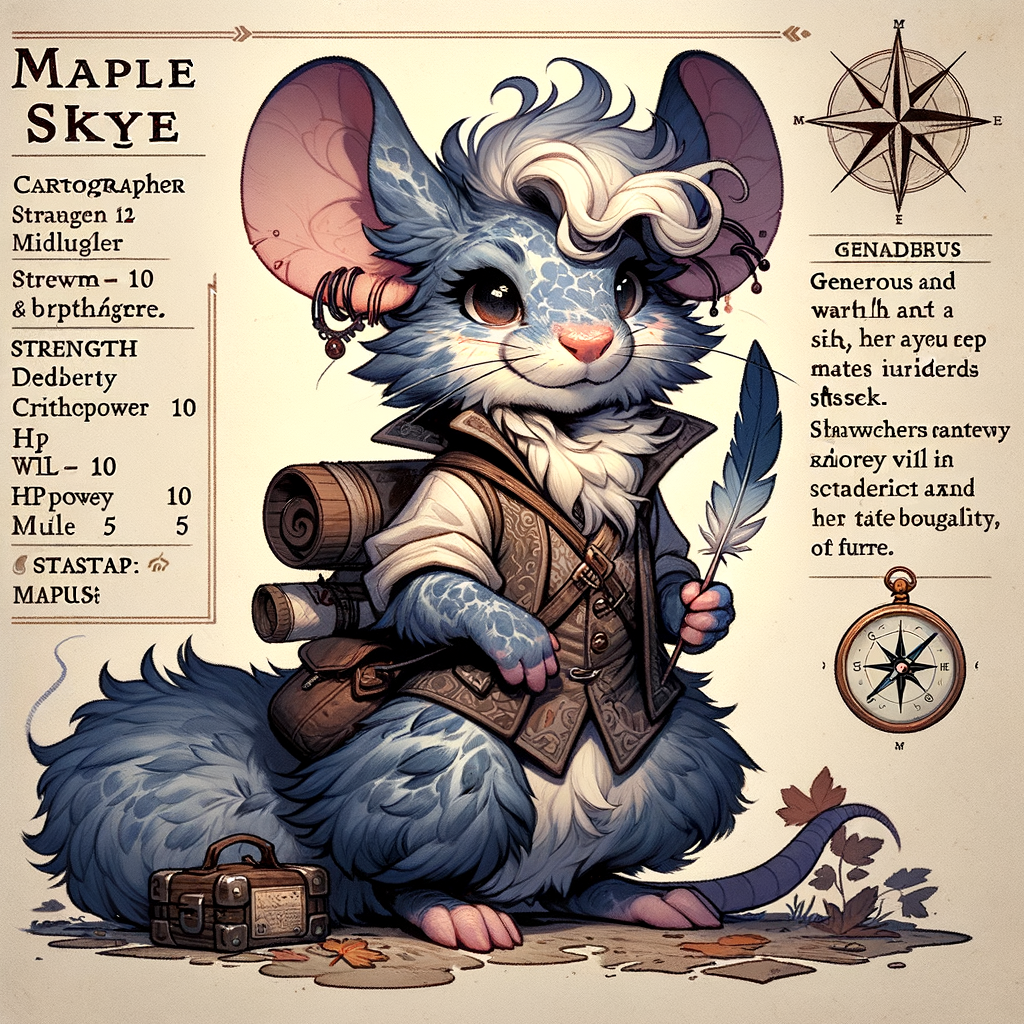

{'image_path': 'dalle/Create_a_fantasy_RPG_style_portrait_of_a_mouse_named_Maple_Skye_Maple_is_a_cartographer_with_a_strik.png',
 'original_prompt': "Portrait of a mouse named Maple Skye, Maple Skye is a talented cartographer adorned with a striking blue marbled coat that reflects her adventurous spirit. Her frizzy fur adds an element of charm to her presence, making her quite memorable. Equipped with a trusty quill and ink for detailed map-making and a compass for navigating her journeys, she sets out to uncover the hidden secrets of the world around her. Known for her generosity, she shares her knowledge with fellow mice, yet her quick temper can spark unexpectedly when matters of integrity are compromised. Maple Skye navigates the delicate balance of kindness and fury, forging paths wherever she goes., wearing Blue, Marbled coat, with Frizzy fur physical detail, in a fantasy RPG style. The mouse has strength 12, dexterity 10, willpower 5, HP 5, and pips (money, max is 6) 2. The mous

In [70]:
# TODO: Use generate_image() to create a portrait for your mouse
generate_image(f"Portrait of a mouse named {my_mouse.name}, {my_mouse.description}, wearing {my_mouse.coat} coat, with {my_mouse.physical_detail} physical detail, in a fantasy RPG style. The mouse has strength {my_mouse.strength}, dexterity {my_mouse.dexterity}, willpower {my_mouse.will}, HP {my_mouse.hp}, and pips (money, max is 6) {my_mouse.pips}. The mouse's background is '{my_mouse.background}', birthsign is '{my_mouse.birthsign}', and disposition is '{my_mouse.disposition}'.")

In [72]:
# What approach did you use to create prompts for DALL-E? What strengths and weaknesses does this approach have? If you tried multiple approaches, how do they compare?
DALLE_APPROACHES = """
I used a two-part prompt where the first part is a general description of the mouse which includes its name, description, coat, and physical detail, as well as the style I want the image to be in.
The second part includes further details about the mouse's attributes, such as strength, dexterity, willpower, HP, pips, background, birthsign, and disposition, in case these would help DALL-E modify the image slightly to reflect these attributes.

I think the image turned out well, and included the items that the mouse has based on its background description. However, there is much improvement to be made to text-generation on the image, as many letters are mixed up or unreadable.
I think the two-part prompt approach works well as it allows both a general description and a further details of the mouse.
Lastly, the generated image looks slightly off, as it has a big squirrel-like tail as well as a mouse tail.
"""

# Part 3: Playing the Game

*Reference: Mausritter rulebook, pg. 12 & pg. 18*

Finally, let's make a GM Kani! If you're familiar with [AI Dungeon](https://aidungeon.com/), the concept here is similar: the model will act as our GM, defining the world and challenges in it. Unlike AI Dungeon, though, we have a character that we created and the ability to roll based off that character sheet!

Let's implement Saves (Mausritter p. 12):

> When you describe your mouse doing something risky where the outcome is uncertain and failure has consequences, the GM will ask you to make a save against either STR, DEX or WIL.
> To make a save, roll a d20. If the result is less than or equal to the relevant attribute, your mouse succeeds, and suffers no consequences. If the result is over the attribute, your mouse fails, and suffers the consequences described by the GM.

Again, we'll make a Kani that subclasses our DiceKani in part 1. You should implement the `roll_save` method that takes in the stat and if the roll is at advantage or disadvantage, and returns whether or not the save was successful.

In [ ]:
class MausritterKani(DiceKani):
    # This Kani should reference your mouse - let's pass it in the constructor.
    def __init__(self, *args, mouse: Mouse, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = mouse

    @ai_function()
    def roll_save(
        self,
        stat: Annotated[str, AIParam("The stat to roll a save for, e.g., 'STR', 'DEX', 'WIL'")],
    ):
        """
        Roll a save for the given stat and compare it to your mouse's stats.
        Args:
            stat (str): The stat to roll a save for, e.g., "STR", "DEX", "WIL".
        Returns:
            str: A message indicating whether the save was successful or failed.
        """
        # Roll a save for the given stat, compare it to your mouse's stats, and tell the LLM if you succeed or fail
        stats = {
            "STR": self.mouse.strength,
            "DEX": self.mouse.dexterity,
            "WIL": self.mouse.will,
        }
        roll_result = int(roll(f"1d20").total)
        if (roll_result > stats[stat]):
            return f"Failed, you rolled a {roll_result} and your {stat} is {stats[stat]}."
        return f"Success, you rolled a {roll_result} and your {stat} is {stats[stat]}."

In [ ]:
# Instruct GPT-4 on how to call the functions you provided to it and high-level instructions to run the game.
# You should also include information on the character you created so the GM can reference it.
# Not sure where to start? Try telling it to introduce the world first.
# You might also want to look at the play example on pg. 18 of the Mausritter rulebook.
GM_PROMPT = f"""
You are the Game Master for a Mausritter game. You will describe the world, the situation, and the challenges that the player faces.
Also familiarize yourself with the character, {my_mouse}.
Depending on the player's actions, you will handle the game state and roll dice as needed.
When the player wants to do something risky where the outcome is uncertain and there are consequences for failure, you will ask them to make a save against one of STR, DEX, or WIL.
If the save is successful, the player succeeds in their action. If the save fails, the player fails and suffers consequences. Use the 'roll_save' function for this.
Begin the game by describing the world and the situation the player is in. Use the mouse's attributes to describe the mouse and its abilities.
"""

In [76]:
# Run this cell to reset the state of your game
# You can also add existing chat_history here if you'd like
gm_ai = MausritterKani(engine, mouse=my_mouse, system_prompt=GM_PROMPT)

Now, explore the world created by your model! When you're done, send `!stop`. The game transcript will be automatically saved to `gm.json`.

In [ ]:
# You can rerun this cell to continue the game
# Send "!stop" when you are done making your mouse
chat_in_terminal(gm_ai, stopword="!stop", verbose=True)
gm_ai.save(f"gm-{int(time.time())}.json")

/var/folders/sc/_5mj781j5315nzv10s8kvs1w0000gn/T/ipykernel_11217/2821132793.py:3: RuntimeWarning: coroutine 'chat_in_terminal_async' was never awaited
  chat_in_terminal_async(gm_ai, stopword="!stop", verbose=True, rounds=10)


## Structureless Comparison

Cool, isn't it? But is it really *better* to provide LLMs with this structured information and access to tools?

To answer this question, let's try playing without structure: only prompt GPT-4 to act as the GM WITHOUT access to your character sheet or dice rolling.

In [78]:
# Instruct GPT-4 on how to act as a Mausritter GM.
# You should NOT include information on function calling, but may tell it about your character (your choice).
GM_PROMPT_STRUCTURELESS = f"""
You are the Game Master for a Mausritter game. You will describe the world, the situation, and the challenges that the player faces.
The player will describe their actions, and you will respond to that action accordingly.
The player's character is {my_mouse}.
"""

In [ ]:
# We'll use an unmodified Kani here -- it won't have access to dice rolling.
gm_ai_structureless = Kani(engine, system_prompt=GM_PROMPT_STRUCTURELESS)

In [ ]:
# You can rerun this cell to continue the game
# Send "!stop" when you are done making your mouse
chat_in_terminal(gm_ai_structureless, stopword="!stop", verbose=True)
gm_ai_structureless.save(f"gm-structureless-{int(time.time())}.json")

Did you notice any significant difference in the gameplay in the short term? How about in the long term? Why do you think this might be? Could you think of any other functions you could expose to the GM to improve its story coherence over multiple play sessions? Write down your thoughts here.

In [ ]:
AI_GM_THOUGHTS = """
I didn't observe much difference between the two GMs. The first GM with knowledge about save rolling did not use the function during my gameplay.
Perhaps the first GM needed more specific instructions for when to roll saves in order to actually use the function. In my gameplay, I engaged in combat, which should in theory result in a save roll for STR, but it did not happen.
However, save rolls did happen when I asked an ally to gather gadgets: DEX for smoke bomb, and WIL for grappling hook.
The second GM performed similarly to the first in terms of telling the story and responding to my actions, but it did not roll saves.
Having never played a game like this, I don't quite know how often saves should be rolled, thus I can't say for sure if any of the GMs were doing it right.
"""

That's it for HW3! Hopefully you've gained an understanding of how structured game state can influence LLMs, and how to use Kani with function calling to give LLMs powerful capabilities. These skills will come in handy as you begin working on your final projects!

## What you should submit

You should submit to Gradescope:
- this notebook with all TODOs and free-response sections completed
- the latest saved transcripts of your character creator agent and play (with a structured and unstructured AI GM)
- the image(s) you generated of your character